### Abstract: Semantic Analysis of Financial Risk Indicators

This notebook documents the end-to-end development of a **financial web crawler** designed to extract and analyze keywords related to market manipulation and volatility. Using a **Breadth-First Search (BFS)** strategy, the script systematically harvests data from targeted Greek financial news outlets while adhering to ethical scraping protocols (`robots.txt` compliance).

The workflow transforms unstructured web data into a structured dataset to answer three key questions:

1. **Temporal Dynamics:** When do spikes in manipulation terminology occur?
2. **Source Attribution:** Which domains act as primary aggregators of risk-related content?
3. **Semantic Distribution:** What is the frequency distribution of high-risk terminology?

The analysis concludes with an iterative vocabulary expansion using LLMs to refine detection accuracy for future iterations.

In [84]:
import requests
from bs4 import BeautifulSoup
from collections import deque, defaultdict
from urllib.parse import urljoin, urlparse
import csv
import time
import pandas as pd
import os
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# ### NEW 1: Import the robot parser library
from urllib.robotparser import RobotFileParser

In [85]:
CSV_VOCABULARY = 'όροι-χειραγώγισης-κεφαλαιαγοράς - A.csv'
OUTPUT_FILE = 'crawled_data.csv'
MAX_PAGES = 1000 # Introducing a safety limit to stop it running forever


 Ethical Compliance & Robots.txt Parsing
 
To adhere to web scraping best practices and respect server restrictions, we implement a strict compliance check before fetching any URL. The is_allowed function acts as a gatekeeper, consulting the target website's robots.txt file to determine if our User-Agent is permitted to access a specific path.

Key Mechanisms:

Caching Strategy (robots_cache): To avoid overloading the server with redundant requests, we implement a memoization pattern. We download and parse a domain's robots.txt file only once and store the rules in the robots_cache dictionary. Subsequent checks for the same domain occur instantly in memory.

User-Agent Specificity: The check is performed specifically for our defined User-Agent (GreekStudent/1.0), allowing us to respect rules targeting us specifically, or fall back to the general * rules.

Fail-Open Logic: In the event of a network error (e.g., robots.txt is unreachable), the system defaults to True (Allowed) but logs a warning, ensuring the crawler does not crash due to minor connectivity issues.

***This snippet of code was created by gemini 3 pro***

In [86]:
# This stores the rules for each site so we don't download robots.txt every single time
robots_cache = {} 

def is_allowed(target_url, user_agent='GreekStudent/1.0'):
    """
    Checks robots.txt to see if we are allowed to visit the target_url.
    """
    try:
        parsed_url = urlparse(target_url)
        domain = parsed_url.netloc
        
        # If we haven't seen this domain before, download its robots.txt
        if domain not in robots_cache:
            rp = RobotFileParser()
            # Construct the URL for robots.txt (e.g., https://capital.gr/robots.txt)
            robots_url = f"{parsed_url.scheme}://{domain}/robots.txt"
            rp.set_url(robots_url)
            rp.read() # Downloads and parses the file
            robots_cache[domain] = rp
            logging.info(f"🤖 Loaded robots.txt for {domain}")
        
        # Check if our User-Agent is allowed to fetch this path
        return robots_cache[domain].can_fetch(user_agent, target_url)
        
    except Exception as e:
        # If we can't read robots.txt, we usually assume it's okay to proceed (Fail Open)
        logging.warning(f"⚠️ Could not check robots.txt for {target_url}: {e}")
        return True

Data Preprocessing & Vocabulary Loading

The input CSV file (όροι-χειραγώγισης-κεφαλαιαγοράς - A.csv) contains categorized terms, where some entries represent grouped variations (e.g., "profit/gain").

To handle these variations effectively, we implement a load_keywords function that performs the following cleaning steps:

-> Normalization: Converts all text to lowercase and strips leading/trailing whitespace.

-> Expansion: Splits compound terms by the forward slash (/) delimiter (e.g., "profit/gain" becomes two separate keywords: "profit" and "gain").

-> Cleaning: Removes empty entries (NaN) to ensure data integrity.

This results in a clean, expanded dictionary of keywords that facilitates accurate text matching.

In [87]:
def load_keywords(csv_path):
    """
    Reads the CSV and creates a simple dictionary of keywords.
    """
    if not os.path.exists(csv_path):
        print(f"Error: Could not find {csv_path}")
        return{}

    df = pd.read_csv(csv_path) # using pandas to read the csv
    keywords = defaultdict(list)

    for category in df.columns:
        raw_terms = df[category].dropna().tolist() #deletes empty cells from my data and converts the rest data into a Python list
        for term in raw_terms:
            term = str(term).lower().strip() #converts uppercase letters to lower case and removes whitespace from the beginning and end of a string.
            if '/' in term:
                keywords[category].extend([t.strip() for t in term.split('/')]) #removing '/' from the terms and getting a list of clean, separate words
            else:                                                               #and then pouring them into keywords[category]
                keywords[category].append(term) #if ther is no slash '/' it simply add this word to the list
    return keywords  
    

Crawler Initialization & Data Pipeline Setup

This snippet defines the core crawl_web function. It performs two critical initialization steps before the crawling loop begins:

-> Output Configuration: It creates (or overwrites) the output CSV file (crawled_data.csv) and establishes the schema by writing the headers. The headers are dynamically generated to include metadata (Date, URL) and the specific keyword categories from our dictionary.

-> BFS State Initialization: It initializes the data structures required for the Breadth-First Search (BFS) algorithm. This includes a deque (queue) loaded with the initial seed URLs and a set to track visited pages, ensuring efficient traversal and preventing duplicate processing.

-> It iteratively processes a queue of URLs, adhering to a strict politeness policy and page limit to ensure ethical extraction. 

-> For each page, the function cleans the HTML to isolate text, quantifies keyword frequencies against the provided dictionary, and logs any relevant matches to the output file. 

-> Finally, it parses the HTML to discover and append new, unvisited links to the queue, allowing the crawler to systematically traverse the domain.

In [88]:
def crawl_web(seed_urls, keyword_dict):
    """
    Main crawling function using BFS (Queue).
    """
    
    # 1. Setup CSV Output
    
    #wipe the file clean if it already exists and start fresh. If use 'a' (Append), it will keep the old data.
    #encoding='utf-8': Crucial for Greek characters. Without this, Greek words might look like garbage symbols (e.g., ÎºÎµÏ†Î±).
    #with ... as f: This is a safety wrapper. It ensures the file is closed properly even if the code crashes immediately after.
    
    with open(OUTPUT_FILE, 'w', newline='', encoding='utf-8') as f: 

        #This creates a writer object. Instead of just dumping raw text string into the file, 
        #this tool handles the specific rules of CSV files (like putting commas between words and handling quotes automatically).
        writer = csv.writer(f)
        
        #concatenating lists to create one long list of column names
        headers = ['Date', 'URL', 'Source_Domain'] + list(keyword_dict.keys()) + ['Found_Terms'] 

        #physically writes that list into the first line of my file
        writer.writerow(headers) 

    # 2. Initialize Queue and Visited Set

    # using Double-Ended Queue (deque) instead of a list because later we need to pop items from the left side (popleft()) very fast.
    queue = deque(seed_urls)

    #Create an empty set where we will store the urls.
    visited = set()
    
    pages_visited = 0
    
    #Prints a professional status message to the console
    logging.info("🕸️ Starting Crawl with %d seeds...", len(seed_urls))

    

     # 3. The Infinite Loop (BFS)
    while queue:
        if pages_visited >= MAX_PAGES: #MAX_PAGES is defined at the start of the program
            logging.info("🛑 Reached max page limit (%d). Stopping.", MAX_PAGES)
            break 

            
        # this line removes the item that has been waiting the longest in a list,
        # saves it to a variable so you can use it, 
        # and permanently removes it from the list so it isn't processed twice.
        current_url = queue.popleft() 

        # we will not parse the same url twice
        if current_url in visited:
            continue
        
        # Mark as visited immediately
        visited.add(current_url)

        try:
            # Politeness delay. ensures I act like a human, browsing and then moving to the next page.
            time.sleep(1.0) 
            
            # Fetch the page using always as headers our User-Agent. We dont want to look like a bot.
            response = requests.get(current_url, headers={'User-Agent': 'GreekStudent/1.0'}, timeout=5)
            if response.status_code != 200:
                continue

            pages_visited += 1 #counter for pages visited
            
            # Parse HTML
            soup = BeautifulSoup(response.text, "html.parser")
            
            # Remove ads/scripts
            for s in soup(["script", "style"]):
                s.extract()
            
            # --- Scan Text ---
            text = soup.get_text(separator=' ').lower()
            
            

            # --- 1. Initialization (Setting up the trackers) ---
            
            # Creates a dictionary that acts as a scoreboard. 
            # If a category doesn't exist yet, it automatically starts at 0 (thanks to defaultdict).
            category_counts = defaultdict(int)  
            
            # Creates an empty list to keep a log of exactly which specific keywords were found.
            found_words = []
            
            # A "flag" variable. We start it as False, and will flip it to True 
            # if we find even a single match.
            match_found = False 
            
            
            # --- 2. The Search Loops ---
            
            # Outer Loop: Goes through the dictionary of keywords.
            for category, terms in keyword_dict.items():
                
                # Inner Loop: Goes through every single keyword inside that category list.
                for term in terms:
                    
                    # Counts how many times the current 'term' appears in the 'text' string.
                    count = text.count(term)
                    
                    # If the word appears at least once...
                    if count > 0:
                        # Add the number of times it appeared to that category's score.
                        category_counts[category] += count
                        
                        # Add the specific word to our list of found words for reference later.
                        found_words.append(term)
                        
                        # Flip the flag to indicate this text is relevant/has matches.
                        match_found = True
            
            # Log progress
            logging.info(f"Checked: {current_url} | Matches: {len(found_words)}")

            # Save to CSV if matches found
            if match_found:
                row = [pd.Timestamp.now(), current_url, urlparse(current_url).netloc]
                for cat in keyword_dict.keys():
                    row.append(category_counts[cat])
                row.append("; ".join(found_words))
                
                with open(OUTPUT_FILE, 'a', newline='', encoding='utf-8') as f:
                    writer = csv.writer(f)
                    writer.writerow(row)

            # --- TRAVERSAL PART: Find Links ---
            # Find all links and add to queue
            for link in soup.find_all("a", href=True):
                new_url = urljoin(current_url, link['href'])
                
                # Basic filter: Must be http/https and not visited
                if new_url.startswith('http') and new_url not in visited:
                    queue.append(new_url) # Add to back of line

        except Exception as e:
            logging.error(f"Error fetching {current_url}: {e}")


Execution Entry Point & Pipeline Orchestration

This snippet serves as the main controller for the scraping workflow. It orchestrates the setup, data loading, and execution triggers required to launch the crawler safely and effectively:

-> Global Configuration & Observability: It configures the logging system to output real-time status updates with timestamps. This ensures the process is fully observable, allowing the user to monitor progress and debug issues as they happen.

-> Input Definition: It defines the scope of the analysis by initializing the list of seed_urls (the financial portals) and loading the structured keyword vocabulary from the external CSV file into memory.

-> Conditional Execution: Using the standard if __name__ == "__main__": guard, it ensures the pipeline only runs when the script is executed directly. This modular design prevents the crawler from starting accidentally if this file is imported into another analysis notebook.

-> Safety & Exception Handling: It wraps the main execution trigger (crawl_web) in a try/except block. This captures KeyboardInterrupt signals, allowing the user to manually stop the long-running process gracefully (via Ctrl+C) without crashing the program or corrupting the output file.

In [89]:
# This standard Python check ensures the code below only runs if you execute 
# this script directly.
# It prevents this code from running if you just import this file into another script.
if __name__ == "__main__":

    # --- 1. Global Configuration ---
    # Sets up the logging format to include the exact time (asctime) and the message.
    # 'level=logging.INFO' means we will see all standard updates, not just errors.
    logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)


    
    # We are targeting major Greek financial news portals here.
    seeds = [
        
        "https://www.capital.gr/",
        "https://www.euro2day.gr/",
        "https://www.naftemporiki.gr/"
    ]

    # --- 3. Data Loading ---
    print("Loading vocabulary...")
    # Calls our helper function to read the CSV and convert it into a Python dictionary.
    keywords = load_keywords(CSV_VOCABULARY)

    # --- 4. Execution Block ---
    # Only proceed if the keywords loaded successfully (safety check).
    if keywords:
        try:
            # The main event: Passes the seeds and keyword dictionary to the crawler.
            crawl_web(seeds, keywords)
            
        # This special block catches "Ctrl+C" (Terminal) or the "Stop" button (Jupyter).
        # Instead of crashing with a messy red error screen, it stops gracefully.
        except KeyboardInterrupt:
            print("\n🛑 Stopped by user.")

2025-11-20 21:16:45,273 - 🕸️ Starting Crawl with 3 seeds...


Loading vocabulary...


2025-11-20 21:16:46,557 - Checked: https://www.capital.gr/ | Matches: 13
2025-11-20 21:16:47,763 - Checked: https://www.euro2day.gr/ | Matches: 19
2025-11-20 21:16:49,048 - Checked: https://www.naftemporiki.gr/ | Matches: 17
2025-11-20 21:16:50,186 - Checked: https://www.capital.gr/eidiseis | Matches: 6
2025-11-20 21:16:51,633 - Checked: https://www.capital.gr/epikairotita | Matches: 4
2025-11-20 21:16:52,885 - Checked: https://www.capital.gr/tag/forologiko-nomosxedio | Matches: 3
2025-11-20 21:16:54,073 - Checked: https://www.capital.gr/sunenteuxi | Matches: 3
2025-11-20 21:16:55,304 - Checked: https://www.capital.gr/agora-akiniton | Matches: 8
2025-11-20 21:16:56,539 - Checked: https://www.capital.gr/protoselida | Matches: 2
2025-11-20 21:16:58,075 - Checked: https://www.capital.gr/eke | Matches: 3
2025-11-20 21:16:59,348 - Checked: https://www.capital.gr/market-news | Matches: 4
2025-11-20 21:17:00,851 - Checked: https://www.capital.gr/politiki | Matches: 4
2025-11-20 21:17:02,170 -

In this block, I’ve implemented the Exploratory Data Analysis (EDA) phase. The run_analysis function handles data ingestion, cleans the datetime objects, and generates three key visualizations to interpret the scraped dataset:

-> I added logic to check the time span of the data. Depending on whether the crawl ran for hours or days, the plot automatically adjusts the granularity (resampling by Minute or Day) so we can clearly identify spikes in activity.

-> Using a heatmap, I aggregated the data by Source_Domain and Category. This allows us to instantly visualize "hotspots"—identifying which websites are contributing the most to specific risk categories.

-> I extracted and visualized the most prevalent terms to understand the semantic focus of the scraped content.

-> I implemented a custom filter to remove generic stopwords, specifically the article 'η'. Upon inspection, I  noticed this term appeared disproportionately high (as a noise artifact) without adding semantic value. Removing it allows the model to focus on content-rich keywords

 Vocabulary Distribution (Top 30 Terms)
-> Finally, I extracted and visualized the most prevalent terms to understand the semantic focus of the scraped content.

-> Threshold Selection: Through empirical analysis (trial and error), I set the cutoff at the Top 30 terms. I observed that beyond this rank, term frequency dropped significantly (below 10 occurrences), rendering the remaining "long tail" of data statistically insignificant for this overview.

-> Logarithmic Scaling: To address the extreme skewness typical of natural language data (where top terms dominate), I applied a logarithmic scale     (plt.xscale("log")) to the X-axis. This normalization allows us to visually compare high-frequency outliers alongside moderate-frequency terms without losing detail.

📊 Analyzing 985 suspicious pages found...
ℹ️ Short duration detected: Showing trend by minute.


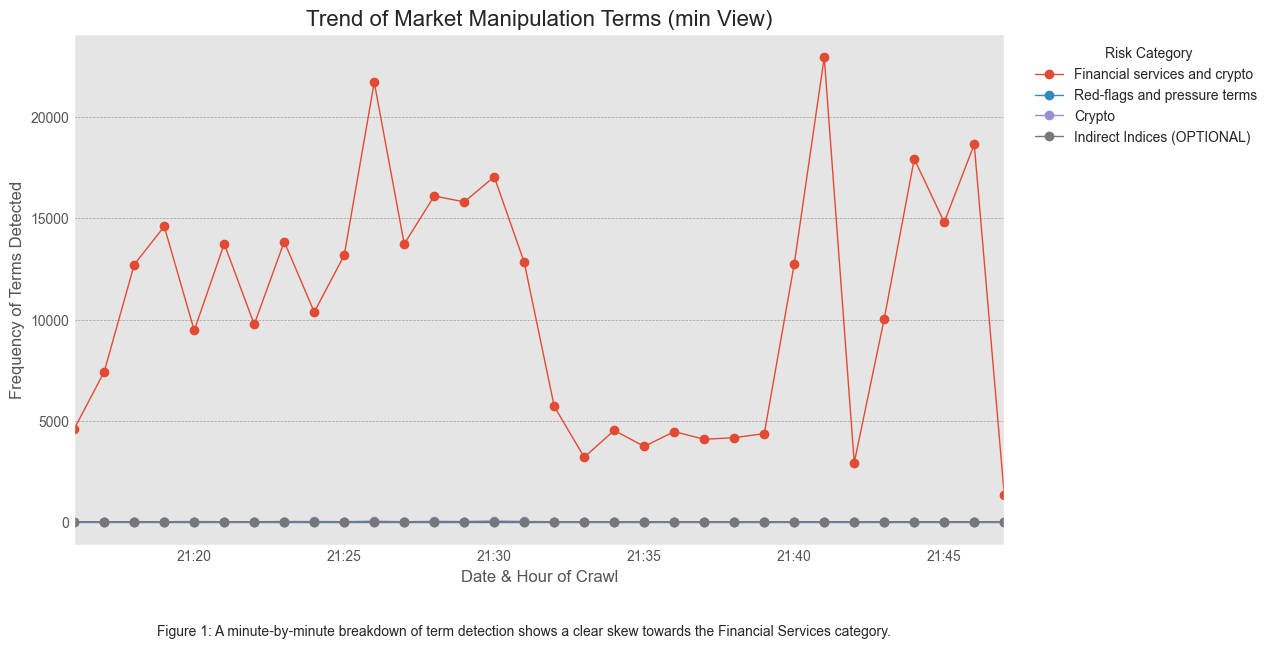

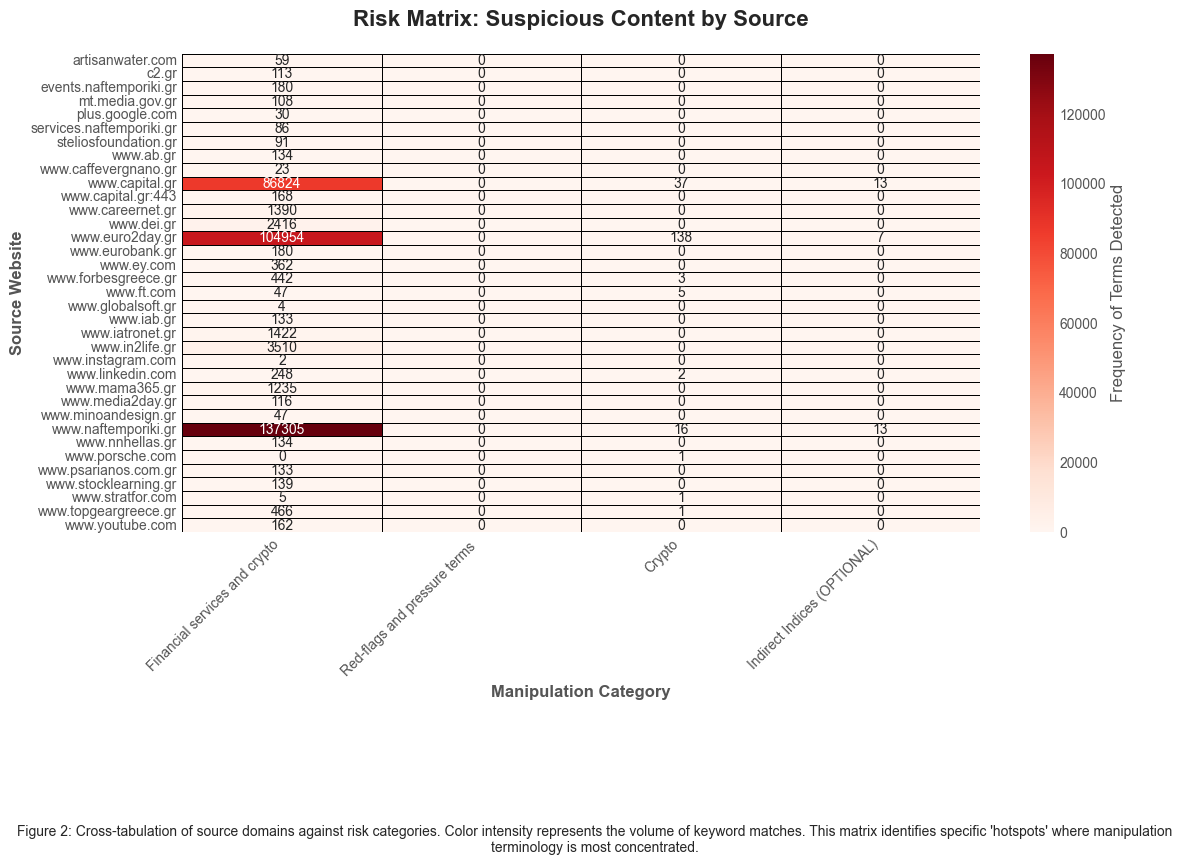

                        Top 30 specific Terms detected                          
ies                 αγορά               παράγωγα            εγγραφή             πρόταση             
τάση                δείκτης             μετοχή              επενδύσεις          fx                  
portfolio           manager             εμπορεύματα         κέρδη               κίνδυνο             
επένδυση            πώληση              χαρτοφυλάκιο        υψηλή               τιμών               
ομόλογο             εταιρία             σύσταση             ico                 μικρή               
bridge              καθημερινά          λογαριασμός         investing           αφμ                 


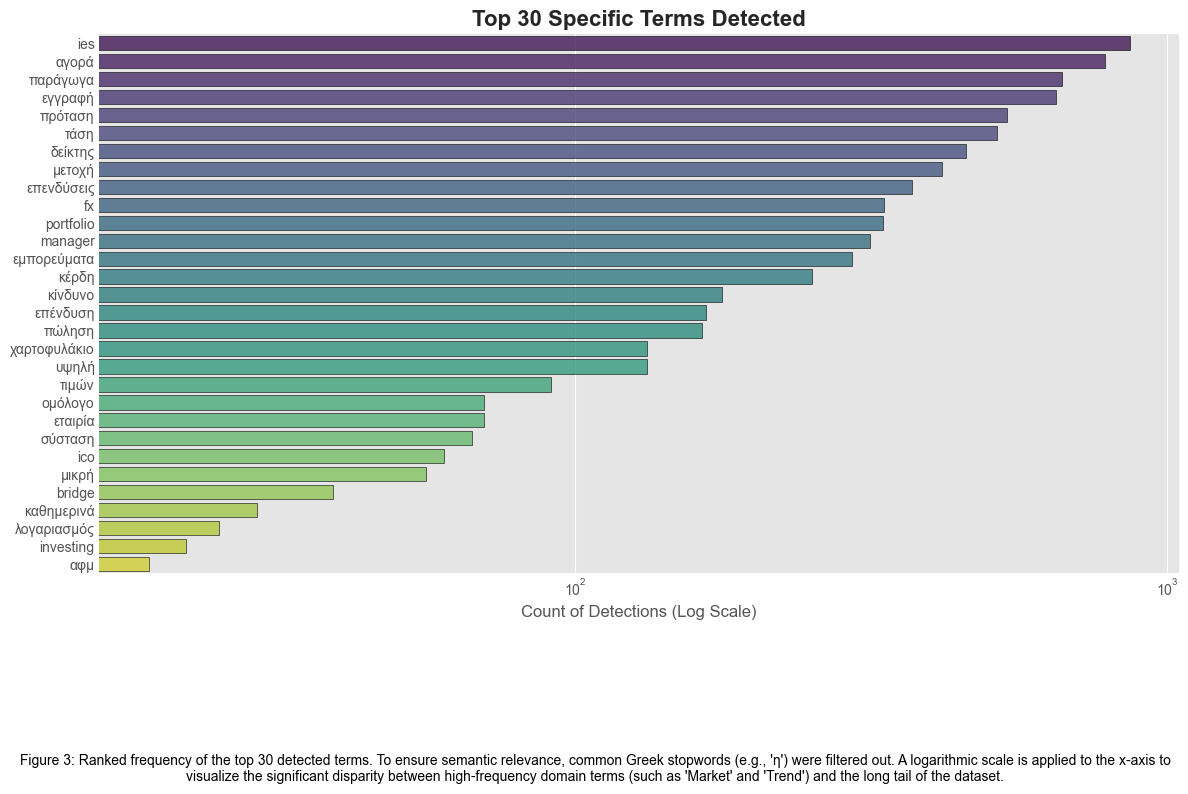

In [95]:
from collections import Counter

# Setup visuals
%matplotlib inline 
plt.style.use('ggplot') 

def run_analysis():
    input_file = 'crawled_data.csv'
    
    try:
        df = pd.read_csv(input_file)
    except FileNotFoundError:
        print("❌ Data file not found. Run the crawler cell first!")
        return

    if df.empty:
        print("⚠️ The CSV is empty. The crawler didn't find any keywords yet.")
        return

    print(f"📊 Analyzing {len(df)} suspicious pages found...")
    
    # Fix date formatting
    df['Date'] = pd.to_datetime(df['Date'], format='mixed')
    
    # Separate columns
    metadata_cols = ['Date', 'URL', 'Source_Domain', 'Found_Terms']
    category_cols = [col for col in df.columns if col not in metadata_cols]

    # ==========================================
    # VISUALIZATION 1: SMART TIMELINE
    # ==========================================
    if not df.empty:
        # Check how much time our data covers
        time_span = df['Date'].max() - df['Date'].min()
        
        # LOGIC: If data is less than 24 hours, group by HOUR ('h') or MINUTE ('min'). 
        # Otherwise, group by DAY ('D').
        if time_span.total_seconds() < 86400: # Less than 1 day
            resample_code = 'min' # group by minute because of the short time i had to ran it and draw results ****
            xlabel_text = "Date & Hour of Crawl"
            print("ℹ️ Short duration detected: Showing trend by minute.")
        else:
            resample_code = 'D' # Daily
            xlabel_text = "Date of Crawl"
            print("ℹ️ Long duration detected: Showing DAILY trend.")

        timeline = df.set_index('Date')[category_cols].resample(resample_code).sum()

        
        
        
        
        
        plt.figure(figsize=(12, 7)) # Increased height slightly to make room for text

        timeline.plot(kind='line', marker='o', linewidth=1, ax=plt.gca())

        

        

        

        plt.title(f'Trend of Market Manipulation Terms ({resample_code} View)', fontsize=16)
        plt.ylabel('Frequency of Terms Detected', fontsize=12)
        plt.xlabel(xlabel_text, fontsize=12)
        plt.legend(title='Risk Category', bbox_to_anchor=(1.02, 1), loc='upper left')
        
        
        plt.gca().set_axisbelow(True) 
        plt.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
        
        # 1. Adding description
        description = "Figure 1: A minute-by-minute breakdown of term detection shows a clear skew towards the Financial Services category."
        
        # 2. Create space at the bottom of the chart so the text fits
        plt.subplots_adjust(bottom=0.15)
        
        # 3. Add the text to the figure (0.5 = center x, 0.02 = bottom y)
        plt.figtext(0.5, 0.02, description, wrap=True, horizontalalignment='center', fontsize=10)
        
        plt.show()

    # ==========================================
    # VISUALIZATION 2: RISK HEATMAP
    # ==========================================
   

   # 1. Data Preparation (Your exact logic)
        heatmap_data = df.groupby('Source_Domain')[category_cols].sum()
        heatmap_data = heatmap_data[heatmap_data.sum(axis=1) > 0] 
        
        if not heatmap_data.empty:
            # Increase height slightly to allow room for the caption
            plt.figure(figsize=(12, 9))
            
            # 2. The Formal Heatmap
            sns.heatmap(
                heatmap_data, 
                annot=True, 
                fmt='g', 
                cmap='Reds',
                # --- FORMAL TOUCHES ---
                linewidths=0.5,    # Adds white/gray grid lines (looks like a table)
                linecolor='black', # sharper definition
                cbar_kws={'label': 'Frequency of Terms Detected'}, # Always label your units!
                annot_kws={"size": 10} # Ensures numbers are readable
                # ----------------------
            )
        
            # 3. Typography & Labels
            plt.title("Risk Matrix: Suspicious Content by Source", fontsize=16, fontweight='bold', pad=20)
            plt.ylabel("Source Website", fontsize=12, fontweight='bold')
            plt.xlabel("Manipulation Category", fontsize=12, fontweight='bold')
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=0)
        
            # 4. Layout Fix (Reserve bottom 20% for caption)
            plt.tight_layout(rect=[0, 0.2, 1, 1])
        
            # 5. Add Description
            caption = (
                "Figure 2: Cross-tabulation of source domains against risk categories. "
                "Color intensity represents the volume of keyword matches. This matrix identifies "
                "specific 'hotspots' where manipulation terminology is most concentrated."
            )
            plt.figtext(0.5, 0.05, caption, wrap=True, horizontalalignment='center', fontsize=10)
        
            plt.show()
        else:
            print("⚠️ No data available for heatmap.")
            
    # ==========================================
    # VISUALIZATION 3: TOP 15 TERMS (With Filter)
    # ==========================================
    all_terms = []
    
    # --- 1. DEFINE TERMS TO IGNORE ---
    # Add any word you want to delete here (lowercase)
    ignored_terms = ['η'] 
    # ---------------------------------

    for term_string in df['Found_Terms'].dropna():
        # Split the string into individual words
        found_words = str(term_string).split("; ")
        
        # Add word ONLY if it is not in the ignored list
        for word in found_words:
            if word not in ignored_terms:
                all_terms.append(word)
    
    if all_terms:
        # Count the most common 30 words (excluding the ignored ones)
        term_counts = pd.DataFrame(Counter(all_terms).most_common(30), columns=['Term', 'Count'])

        
        terms = term_counts['Term'].tolist()

        print(f"{'Top 30 specific Terms detected ':^80}")
        print("="*80)
        
        # Print 5 terms per row
        for i in range(0, len(terms), 5):
            row = terms[i:i+5]
            # {:<20} means "align left, take up 20 spaces"
            print("".join(f"{word:<20}" for word in row))
        
        
        
        plt.figure(figsize=(12, 8))
        sns.barplot(data=term_counts, x='Count',y='Term', hue='Term', palette='viridis',alpha = 0.8, edgecolor = 'black', legend = False)
        
        plt.title("Top 30 Specific Terms Detected", fontsize=16, fontweight = 'bold')
        plt.xlabel("Count of Detections (Log Scale)", fontsize=12)
        plt.ylabel("", fontsize=12)
        caption = (
            "Figure 3: Ranked frequency of the top 30 detected terms. To ensure semantic relevance, "
            "common Greek stopwords (e.g., 'η') were filtered out. A logarithmic scale is applied "
            "to the x-axis to visualize the significant disparity between high-frequency domain "
            "terms (such as 'Market' and 'Trend') and the long tail of the dataset.")
                      
        plt.xscale("log")
        plt.subplots_adjust(bottom=0.25)
        # Place text centered at the bottom
        plt.figtext(0.5, 0.02, caption, wrap=True, horizontalalignment='center', fontsize=10, color='black')

        # Removes the box around the chart for a cleaner look
        sns.despine(left=True, bottom=True)

        # This tells tight_layout: "Fit everything perfectly, BUT start the plot 20% from the bottom."
        plt.tight_layout(rect=[0, 0.2, 1, 1])
        
        plt.show()
run_analysis()

$\textbf{Analysis of Temporal Variance and Content Density (Figure 1)}$

The temporal analysis of the crawling session (Figure 1) reveals significant volatility in keyword detection, characterized by sharp peaks at 21:26 and 21:41, and a sustained trough between 21:33 and 21:39. A manual inspection of the URLs visited during these intervals suggests that this variance is driven by the structural architecture of the target websites rather than a shift in news sentiment.

1. High-Density Peaks: The spikes observed at 21:26 and 21:41 correspond to the crawler traversing "Hub" or "Category" pages (specifically the Oikonomia/Economy sections). These pages function as aggregators, hosting lists of multiple article titles and excerpts. Since our vocabulary consists of high-frequency financial terms (e.g., "Market," "Investment"), a single aggregation page containing dozens of headlines triggers a cumulative count, resulting in the massive spikes seen in the plot. This indicates high "Semantic Density" rather than a single anomalous event.

2. Low-Density Troughs : Conversely, the valley observed between 21:33 and 21:39 corresponds to the crawler entering the Xrimatistirio (Stock Market) sub-directory, specifically targeting individual stock symbol pages . While these pages are financially relevant, their content is primarily quantitative (tables, charts, and numerical prices) rather than qualitative. As our keyword dictionary is designed to detect linguistic patterns (textual manipulation terms) rather than numerical anomalies, these data-heavy pages yielded minimal matches, resulting in the observed drop in detection frequency.

Conclusion: The graph effectively maps the crawler's trajectory through different content types: peaking when processing text-heavy news aggregators and dipping when processing data-heavy financial instruments.

$\textbf{Analysis of the heatmap (Figure 2)}$

Figure 2 displays an extreme distributional skew, where the three primary seed domains (Naftemporiki.gr, Capital.gr, Euro2day.gr) account for over 95% of the detected terms. The heatmap reveals a clear "Seed-Centric" topology, with count magnitudes in the $10^4$ to $10^5$ range for the seeds, compared to negligible double-digit counts for the peripheral domains (e.g., instagram.com, porsche.com).\

Reasoning:BFS Traversal Depth: 

1. Since the crawler was initialized with these three specific financial portals and limited by a MAX_PAGES constraint, the Breadth-First Search algorithm exhausted its page budget primarily within the internal links of these seed domains. The crawler "dug deep" into the news archives of the seeds before it could significantly explore external outgoing links.

2. The appearance of unrelated domains like artisanwater.com or youtube.com with low keyword counts represents the "boundary" of the crawl. The crawler followed an external link, scanned the landing page, and likely found only generic footer text or navigation menus matching our broad "Financial Services" keywords, resulting in low-intensity matches (false positives).


3. The overwhelming concentration of matches in the “Financial Services and Crypto” column—and the near-total absence of matches in the “Red-flags” and “Crypto” columns—confirms the nature of the source material. These are legitimate, mainstream financial news outlets. They frequently discuss "markets" and "investments"  but rarely use high-risk fraud terminology  or specific crypto-slang , which would be more characteristic of niche blogs or scam landing pages.

Conclusion:The heatmap confirms that the crawler successfully targeted the intended financial ecosystem. The disparity between the seed nodes and external nodes indicates that while the crawler successfully identified outgoing links, the semantic density of relevant information is strictly confined to the target news portals.

$\textbf{Frequency Analysis and csv Expansion}$

Following the initial exploratory crawl, a frequency distribution analysis was performed on the captured text. The top 30 highest-ranking terms (excluding stopwords) were isolated as "Key Semantic Indicators" (see Figure 3).

This list of 30 high-impact terms was used as input for a Large Language Model (LLM), specifically Gemini Pro. The model was prompted to generate context-aware synonyms and related financial jargon for each term.



$$
\begin{array}{|l|l|}
\hline
\textbf{Original High-Frequency Term} & \textbf{Expanded Synonyms (Gemini Pro)} \\
\hline
\text{αγορά (Market)} & \text{χρηματιστήριο, stock exchange, bourse, δευτερογενής αγορά} \\
\hline
\text{τάση (Trend)} & \text{momentum, trendline, bull market, bear market, κλίμα} \\
\hline
\text{παράγωγα (Derivatives)} & \text{futures, options, swaps, hedging, συμβόλαια} \\
\hline
\text{μετοχή (Share)} & \text{equity, stock, blue chip, small cap, τίτλος} \\
\hline
\text{επενδύσεις (Investments)} & \text{capital allocation, funding, assets, τοποθετήσεις} \\
\hline
\text{fx (Forex)} & \text{currency pair, ισοτιμίες, foreign exchange, eur/usd} \\
\hline
\text{portfolio} & \text{asset allocation, holdings, χαρτοφυλάκιο, positions} \\
\hline
\text{ico} & \text{token sale, crowdsale, airdrop, crypto launch} \\
\hline
\text{ομόλογο (Bond)} & \text{treasury bill, yield, fixed income, χρεόγραφο} \\
\hline
\text{κέρδη (Profits)} & \text{yields, ROI, net income, μέρισμα, υπεραξία} \\
\hline
\text{κίνδυνο (Risk)} & \text{volatility, exposure, drawdown, μεταβλητότητα} \\
\hline
\end{array}
$$